In [202]:
# import the packages and functions

# auto-reload edited modules
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.insert(0, "/home/mmurakami/crios_backups/an_helper_functions")

# run the script into the current kernel (vars/functions become available)
%run -i "/home/mmurakami/crios_backups/an_helper_functions/load_packages.py"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [203]:
maxx = 2
maxy = 521

(0.0, 10.0)

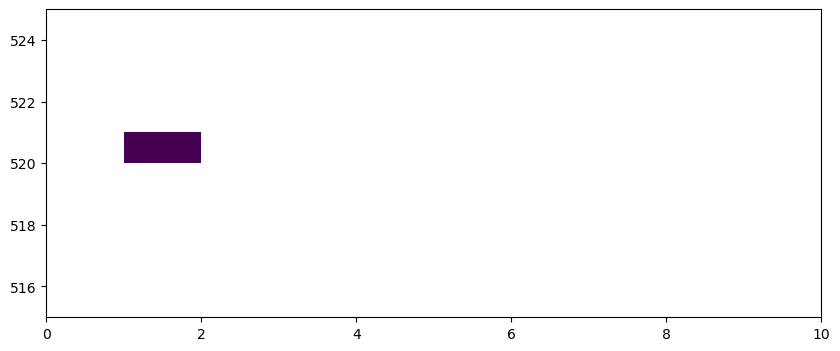

In [204]:
mymsk = np.zeros((ny,nx))
mymsk[520:maxy,1:maxx] = 1
mymsk[mymsk==0]= np.nan
plt.pcolormesh(mymsk)
plt.ylim(515,525)
plt.xlim(0,10)

In [205]:
forward_path = "/scratch/atnguyen/aste_270x450x180/OFFICIAL_ASTE_R1_Sep2019/"
layers_path = "/scratch3/atnguyen/aste_270x450x180/run_c68v_layers_lessmem1_adxOFF_Jan2007_capxxN50_it0062_pk0000262944_bro/"
dirdiags = forward_path + "diags/BUDG/"
dirState = forward_path + "diags/STATE/"
dirLayers = layers_path + "diags/LAYERS/"

In [206]:
# load the TS bins
boundsT = np.round(np.squeeze(rdmds(layers_path + "layers2TH")).ravel(),1)
nT = boundsT.size - 1
boundsS = np.round(np.squeeze(rdmds(layers_path + "layers1SLT")).ravel(),1)
nS = boundsS.size - 1

binwidthT = boundsT[1:] - boundsT[:-1]
binwidthS = boundsS[1:] - boundsS[:-1]

binwidthT1 = 0.5 * (binwidthT[1:] + binwidthT[:-1])
binwidthS1 = 0.5 * (binwidthS[1:] + binwidthS[:-1])

binmidT = (boundsT[1:] + boundsT[:-1]) /2
binmidS = (boundsS[1:] + boundsS[:-1]) /2

nT = nT
nS = nS
nTm1 = nT-1
nSm1 = nS-1

In [207]:
# define tstep 
dt_aste = 600
startyr = 2002
endyr = 2019

# all the filenames in the system
fnames = get_fnames(dt_aste,startyr,endyr)

times = {}
times['2007'] = np.arange(3,4,1)
# times['2008'] = np.array([1])
print(times)

# the filenames we want for 2014
tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)
tsstr

{'2007': array([3])}


array(['0000271440'], dtype='<U32')

In [208]:
mymsk3d = np.tile(mymsk[np.newaxis,:,:],(nz,1,1))
t2 = int(tsstr[0])
hf = mygrid['hFacC']

# load THETA
file_name = "state_3d_set1"
meta_state_3d_set1 = parsemeta(layers_path + "diags/STATE/" + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_state_3d_set1["fldList"])
varnames = np.array(["THETA","SALT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
THETA,its,meta = rdmds(os.path.join(layers_path + "diags/STATE/", file_name),t2,returnmeta=True,rec=recs[0])
SALT,its,meta = rdmds(os.path.join(layers_path + "diags/STATE/", file_name),t2,returnmeta=True,rec=recs[1])
THETA = THETA.reshape(nz,ny,nx)
SALT = SALT.reshape(nz,ny,nx)

# LOAD ADV FOR BOTH T AND S
file_name = "budg3d_hflux_set2"
meta_budg3d_hflux_set2 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_hflux_set2["fldList"])
varnames = np.array(["ADVx_TH","ADVy_TH","ADVx_SLT","ADVy_SLT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVx_TH,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[0])
ADVy_TH,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[1])
ADVx_SLT,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[2])
ADVy_SLT,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[3])

# now 3d zfluxes
file_name = "budg3d_zflux_set2"
meta_budg3d_zflux_set1 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_zflux_set1["fldList"])
varnames = np.array(["ADVr_TH","ADVr_SLT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVr_TH,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[0])
ADVr_SLT,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[1])
ADVr_TH = ADVr_TH.reshape(nz,ny,nx)
ADVr_SLT = ADVr_SLT.reshape(nz,ny,nx)

# for temp, get convergence
ADV_hconvT = calc_UV_conv_mod(nfx, nfy,get_aste_faces(ADVx_TH.reshape(nz, ny, nx), nfx, nfy),get_aste_faces(ADVy_TH.reshape(nz, ny, nx), nfx, nfy))
ADV_hconvT = ADV_hconvT * hf   # degC·m^3/s at cell centers (matches: ff.DFh = ff.DFh .* hf)
ADVhT = ADV_hconvT
trWtopADV = -(ADVr_TH)
ADVrT = np.zeros((nz,ny,nx),dtype=float)
ADVrT[:-1,:,:] = (trWtopADV[:-1] - trWtopADV[1:])
# for salt
ADV_hconvS = calc_UV_conv_mod(nfx, nfy,get_aste_faces(ADVx_SLT.reshape(nz, ny, nx), nfx, nfy),get_aste_faces(ADVy_SLT.reshape(nz, ny, nx), nfx, nfy))
ADV_hconvS = ADV_hconvS * hf   # degC·m^3/s at cell centers (matches: ff.DFh = ff.DFh .* hf)
ADVhS = ADV_hconvS
trWtopADV = -(ADVr_SLT)
ADVrS = np.zeros((nz,ny,nx),dtype=float)
ADVrS[:-1,:,:] = (trWtopADV[:-1] - trWtopADV[1:])

In [209]:
ADVhT.shape

(50, 1350, 270)

In [210]:
np.where(~np.isnan(ADVhT* mymsk3d))
ADVhT.shape

(50, 1350, 270)

In [215]:
print(ADVhT[0,520,1] + ADVhT[0,520,2])
print()
a = ADVx_TH.reshape((nz,ny,nx))
b = ADVy_TH.reshape((nz,ny,nx))
print(-b[0,521,1]) #top
print(b[0,520,1]) #bot
print(a[0,520,1]) #left
print(-a[0,520,2]) #right
print()

print(-(b[0,521,1] + b[0,521,2])+ (b[0,520,1]  + b[0,520,2])  + a[0,520,1] -a[0,520,3]) 

13822.923434249848

11202.045025333804
-10971.649309481058
-3017.961033159094
6861.812168586988

13822.92343424985


In [101]:
# create the G_T term
# define the ADVh total for this mymsk2
G_T_offline_new = np.zeros((2, nT-1))
ADV_Tnew = np.zeros((2, nT-1))
Lijnew = np.zeros((2, nT-1), dtype=int)
# also mask these by mymsk3
# flatten the 3D arrays along all dimensions, as MATLAB’s tmp(:) does
T_flat    = np.ravel(THETA* mymsk3d, order='F')
ADVh_flat = np.ravel(ADVhT* mymsk3d,  order='F')
ADVr_flat = np.ravel(ADVrT* mymsk3d,  order='F')
for i in range(nT-1):
    # MATLAB: ij = find(tmp(:) >= bbb.binmidT(i) & tmp(:) < bbb.binmidT(i+1))
    ij = np.where((T_flat >= binmidT[i]) & (T_flat < binmidT[i + 1]))[0]
    Lijnew[0, i] = len(ij)

    if len(ij) > 0:
        # MATLAB: dF_Tnew(4,i)=sum(ff.advh(ij)); dF_Tnew(5,i)=sum(ff.advr(ij));
        ADV_Tnew[0, i] = np.nansum(ADVh_flat[ij])
        ADV_Tnew[1, i] = np.nansum(ADVr_flat[ij])

G_T_offline_new = ADV_Tnew / binwidthT1[None, :]

G_S_offline_new = np.zeros((2, nS-1))
ADV_Snew = np.zeros((2, nS-1))
Lijnew = np.zeros((2, nS-1), dtype=int)
# also mask these by mymsk3
# flatten the 3D arrays along all dimensions, as MATLAB’s tmp(:) does
S_flat    = np.ravel(SALT* mymsk3d, order='F')
ADVh_flat = np.ravel(ADVhS* mymsk3d,  order='F')
ADVr_flat = np.ravel(ADVrS* mymsk3d,  order='F')
for i in range(nS-1):
    # MATLAB: ij = find(tmp(:) >= bbb.binmidT(i) & tmp(:) < bbb.binmidT(i+1))
    ij = np.where((S_flat >= binmidS[i]) & (S_flat < binmidS[i + 1]))[0]
    Lijnew[0, i] = len(ij)

    if len(ij) > 0:
        # MATLAB: dF_Tnew(4,i)=sum(ff.advh(ij)); dF_Tnew(5,i)=sum(ff.advr(ij));
        ADV_Snew[0, i] = np.nansum(ADVh_flat[ij])
        ADV_Snew[1, i] = np.nansum(ADVr_flat[ij])

# MATLAB: G_T_offline_new = dF_Tnew ./ repmat(bbb.binwidthT1,[6 1])
G_S_offline_new = ADV_Snew / binwidthS1[None, :]

In [102]:
# read the gates
ADVx_TH = ADVx_TH.reshape((nz,ny,nx))
ADVy_TH = ADVy_TH.reshape((nz,ny,nx))


mymsk[520:maxy,1:10] = 1


ADV_gate = np.zeros((nz,ny,nx))
ADV_gate[:,maxy-1,1:maxx] -= ADVy_TH[:,maxy,1:maxx]
ADV_gate[:,520,1:maxx] += ADVy_TH[:,520,1:maxx]
ADV_gate[:,520:maxy,1] += ADVx_TH[:,520:maxy,1]
ADV_gate[:,520:maxy,maxx-1] -= ADVx_TH[:,520:maxy,maxx]

In [103]:
def _bincount_sum_with_nan(idx, vals, nout):
    """
    NaN-aware per-bin sum:
    if *all* entries in a bin are NaN, that bin returns NaN;
    otherwise NaNs are ignored and finite values are summed.
    """
    # track counts of non-nan contributions
    finite = np.isfinite(vals)
    sums   = np.bincount(idx[finite], vals[finite], minlength=nout).astype(float)
    counts = np.bincount(idx[finite], None, minlength=nout).astype(float)
    out = sums
    out[counts == 0] = np.nan
    return out

In [104]:
# define a function to turn the gates as 3D into 1D for T and S
def gateway3D(ADV_west,tracer,binmidTracer,nTm1):
    tracer_flat = tracer.ravel()
    bin_idx_mid = np.digitize(tracer_flat, binmidTracer, right=False) - 1
    valid_mid   = (bin_idx_mid >= 0) & (bin_idx_mid < nTm1) & np.isfinite(tracer_flat)
    idx_mid     = bin_idx_mid[valid_mid]

    # flatten these so we can bin
    ADV_west_flat   = ADV_west.ravel()

    # per-bin sums with NaN-propagation
    ADVh_BSO = _bincount_sum_with_nan(idx_mid, ADV_west_flat[valid_mid], nTm1)
    
    # edge-based G (m^3/s): divide by edge binwidths
    # this is not correct because we want to divide by Face T
    G_BSO = ADVh_BSO #/ binwidthT1

    return G_BSO

In [105]:
theta_flat = THETA.ravel()
salt_flat = SALT.ravel()

G_BSOT = gateway3D(ADV_gate,THETA,binmidT,nTm1)

In [106]:
print(np.nansum(ADV_Tnew[0]) / np.nansum(binwidthT1))
print(np.nansum((G_BSOT)) / np.nansum(binwidthT1))  # in m^3/s

177.30233404177793
86.01335383375678


In [67]:
# let's do the salt as well here for our 2x9
# read the gates
ADVx_SLT = ADVx_SLT.reshape((nz,ny,nx))
ADVy_SLT = ADVy_SLT.reshape((nz,ny,nx))

# mymsk[520:522,1:10] = 1

ADV_gate = np.zeros((nz,ny,nx))
ADV_gate[:,521,1:maxx] -= ADVy_SLT[:,522,1:maxx]
ADV_gate[:,520,1:maxx] += ADVy_SLT[:,520,1:maxx]
ADV_gate[:,520:522,1] += ADVx_SLT[:,520:522,1]
ADV_gate[:,520:522,maxx-1] -= ADVx_SLT[:,520:522,maxx]

G_BSOS = gateway3D(ADV_gate,SALT,binmidS,nSm1)

In [68]:
print(np.nansum(ADV_Snew[0]) / np.nansum(binwidthS1))
print(np.nansum((G_BSOS)) / np.nansum(binwidthS1))  # in m^3/s

847.4484400344094
-0.5647158948379584


In [69]:
# add these as an explicit printout
print("ASTE 270 Heat Budget")

print("from ADV G term: ",np.nansum(ADV_Tnew[0]) / np.nansum(binwidthT1), " m^3/s")
print("from gates: ",np.nansum((G_BSOT)) / np.nansum(binwidthT1), " m^3/s")  # in m^3/s

print()

print("ASTE 270 Salt Budget")

print("from ADV G term: ",np.nansum(ADV_Snew[0]) / np.nansum(binwidthS1), " m^3/s")
print("from gates: ",np.nansum((G_BSOS)) / np.nansum(binwidthS1), " m^3/s")  # in m^3/s

ASTE 270 Heat Budget
from ADV G term:  177.30233404177793  m^3/s
from gates:  86.01335383375678  m^3/s

ASTE 270 Salt Budget
from ADV G term:  847.4484400344094  m^3/s
from gates:  -0.5647158948379584  m^3/s


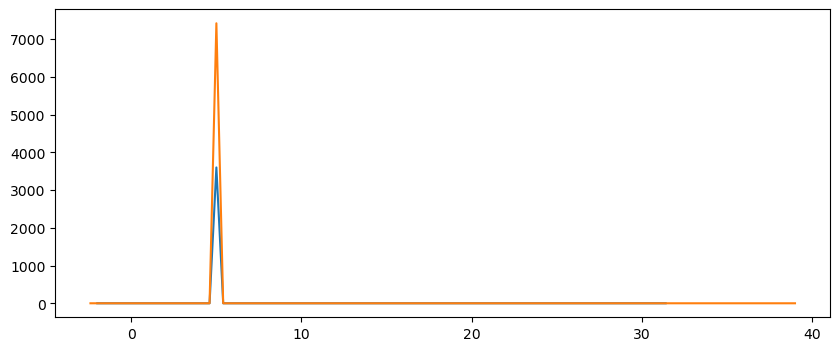

In [70]:
plt.plot(boundsT.flatten()[1:-1],G_BSOT)
plt.plot(boundsT.flatten()[1:-1],ADV_Tnew[0])

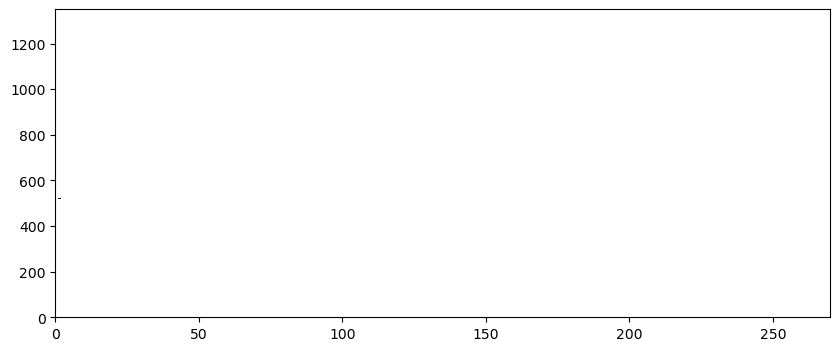

In [216]:
# verify each gate individually of the big ASTE
plt.pcolormesh(mymsk)

## try ASTE 90:

In [153]:
# auto-reload edited modules
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.insert(0, "/home/mmurakami/crios_backups/an_helper_functions")

# run the script into the curre nt kernel (vars/functions become available)
%run -i "/home/mmurakami/crios_backups/an_helper_functions/prep_grid_aste_90.py"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
(450, 90)
RAC2d (40500,)
(100,)


In [154]:
dirroot = "/scratch3/atnguyen/aste_90x150x60/"
dirgrid = dirroot + "GRID_real8/"
dirgridnb = dirroot + "GRID_noblank/"
runstr= "run_c68v_heffmosm3x_layers_lessmem1_viscAHp5em2_it0000_pk0000000001/"
layers_path = dirroot + runstr
extL = "LAYERS"
dirmask = dirroot + "run_template/input_maskTransport/"
dirbudg = layers_path + "diags/BUDG/"
dirdiags = dirbudg
dirstate = layers_path + "diags/STATE/"
dirlayers = layers_path + "diags/LAYERS/"
dirtrsp = layers_path + "diags/TRSP/"

In [155]:
# try to use rdmds
fileprefix = "/scratch3/atnguyen/aste_90x150x60/"
extBasin='run_template/input_maskTransport/'
filename = fileprefix + extBasin + "GATE_transports_v2_mskBasin.bin"
ind = np.fromfile(filename, dtype=np.int32)  # auto-reads .meta for shape/dtype/order
orig_shape = (ind.shape)

ind2d = ind.reshape(ny,nx)

mymsk = np.full((ny,nx),np.nan)
mymsk[ind2d == 57408.0] = 1

# make this smaller
mymsk[:,27:50] = np.nan
mymsk[:160,12:30] = np.nan
mymsk[160:163,15:30] = np.nan

ind = ind.reshape(ny,nx)
mymsk = np.full((ny,nx),np.nan)
mymsk[ind == 57408.0] = 1

# make this smaller
mymsk[:,27:50] = np.nan
mymsk[:160,12:30] = np.nan
mymsk[160:163,15:30] = np.nan

(0.0, 50.0)

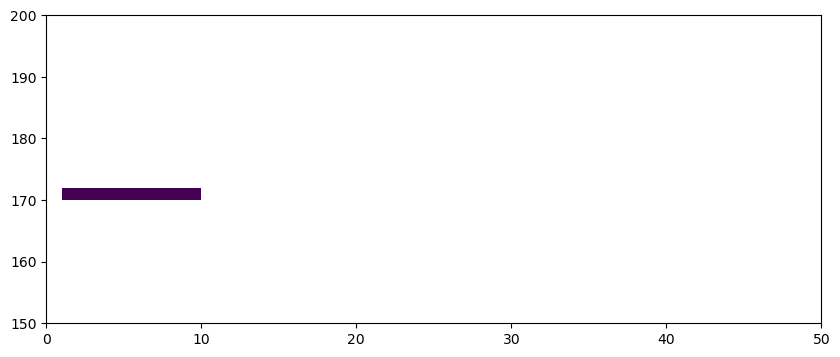

In [156]:
mymsk = np.zeros((ny,nx))
mymsk[170:172,1:10] = 1
mymsk[mymsk==0]= np.nan
plt.pcolormesh(mymsk)
plt.ylim(150,200)
plt.xlim(0,50)

In [157]:
# we need to also create the theta and salt bins for this area
tsstr = np.array(["0000000002","0000000003"])
t2 = int(tsstr[1]) # for the offline version

In [158]:
dirdiags

'/scratch3/atnguyen/aste_90x150x60/run_c68v_heffmosm3x_layers_lessmem1_viscAHp5em2_it0000_pk0000000001/diags/BUDG/'

In [159]:
file_name = "budg3d_hflux_set2"
meta_budg3d_hflux_set2 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_hflux_set2["fldList"])
varnames = np.array(["ADVx_TH","ADVy_TH","ADVx_SLT","ADVy_SLT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVx_TH,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[0])
ADVy_TH,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[1])
ADVx_SLT,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[2])
ADVy_SLT,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[3])

# now 3d zfluxes
file_name = "budg3d_zflux_set1"
meta_budg3d_zflux_set1 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_zflux_set1["fldList"])
varnames = np.array(["ADVr_TH"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVr_TH,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[0])
ADVr_TH = ADVr_TH.reshape(nz,ny,nx)
file_name = "budg3d_zflux_set2"
meta_budg3d_zflux_set2 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_zflux_set2["fldList"])
varnames = np.array(["ADVr_SLT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVr_SLT,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[0])
ADVr_SLT = ADVr_SLT.reshape(nz,ny,nx)

# make the convergences
hf = mygrid['hFacC']

ADV_hconv = calc_UV_conv_mod(nfx, nfy,get_aste_faces(ADVx_TH.reshape(nz, ny, nx), nfx, nfy),get_aste_faces(ADVy_TH.reshape(nz, ny, nx), nfx, nfy))
ADV_hconv = ADV_hconv * hf   # degC·m^3/s at cell centers (matches: ff.DFh = ff.DFh .* hf)
ADVhT = ADV_hconv
trWtopADV = -(ADVr_TH)
ADVrT = np.zeros((nz,ny,nx),dtype=float)
ADVrT[:-1,:,:] = (trWtopADV[:-1] - trWtopADV[1:])  # this is not the way we did it in the original code but this is the way An has done it so we try

ADV_hconvS = calc_UV_conv_mod(nfx, nfy,get_aste_faces(ADVx_SLT.reshape(nz, ny, nx), nfx, nfy),get_aste_faces(ADVy_SLT.reshape(nz, ny, nx), nfx, nfy))
ADV_hconvS = ADV_hconvS * hf   # PSU·m^3/s at cell centers (matches: ff.DFh = ff.DFh .* hf)
ADVhS = ADV_hconvS
trWtopADV = -(ADVr_SLT)
ADVrS = np.zeros((nz,ny,nx),dtype=float)
ADVrS[:-1,:,:] = (trWtopADV[:-1] - trWtopADV[1:])


In [160]:
print(ADVhT[0,170,1])
a = ADVx_TH.reshape((nz,ny,nx))
b = ADVy_TH.reshape((nz,ny,nx))
print(-a[0,171,1]) #top
print(a[0,170,1]) #bot
print(b[0,170,1]) #left
print(-b[0,170,2]) #right
print()

print(-a[0,171,1]+ a[0,170,1] + b[0,170,1] +-b[0,170,2]) 

6903.044352373631
5118.183465812264
-26473.392778612964
-14806.158326086279
89581.63406071014

53420.266421823166


In [161]:
t2 = int(tsstr[1])
# 'diags/state_3d_set1'
# read theta and salt averages from the t2 timestep (average)
file_name = "state_3d_set1"
meta_state_3d_set1 = parsemeta(dirstate + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_state_3d_set1["fldList"])
varnames = np.array(["THETA","SALT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
THETA,its,meta = rdmds(os.path.join(dirstate, file_name),t2,returnmeta=True,rec=recs[0])
SALT,its,meta = rdmds(os.path.join(dirstate, file_name),t2,returnmeta=True,rec=recs[1])

THETA = THETA.reshape(nz,ny,nx)
SALT = SALT.reshape(nz,ny,nx)

In [162]:
mymsk3d = np.tile(mymsk[np.newaxis,:,:],(nz,1,1))
mymsk3d[1:] = 0

In [163]:
# create the G_T term
# define the ADVh total for this mymsk2
G_T_offline_new = np.zeros((2, nT-1))
ADV_Tnew = np.zeros((2, nT-1))
Lijnew = np.zeros((2, nT-1), dtype=int)
# also mask these by mymsk3
# flatten the 3D arrays along all dimensions, as MATLAB’s tmp(:) does
T_flat    = np.ravel(THETA* mymsk3d, order='F')
ADVh_flat = np.ravel(ADVhT* mymsk3d,  order='F')
ADVr_flat = np.ravel(ADVrT* mymsk3d,  order='F')
for i in range(nT-1):
    # MATLAB: ij = find(tmp(:) >= bbb.binmidT(i) & tmp(:) < bbb.binmidT(i+1))
    ij = np.where((T_flat >= binmidT[i]) & (T_flat < binmidT[i + 1]))[0]
    Lijnew[0, i] = len(ij)

    if len(ij) > 0:
        # MATLAB: dF_Tnew(4,i)=sum(ff.advh(ij)); dF_Tnew(5,i)=sum(ff.advr(ij));
        ADV_Tnew[0, i] = np.nansum(ADVh_flat[ij])
        ADV_Tnew[1, i] = np.nansum(ADVr_flat[ij])

G_T_offline_new = ADV_Tnew / binwidthT1[None, :]

G_S_offline_new = np.zeros((2, nS-1))
ADV_Snew = np.zeros((2, nS-1))
Lijnew = np.zeros((2, nS-1), dtype=int)
# also mask these by mymsk3
# flatten the 3D arrays along all dimensions, as MATLAB’s tmp(:) does
S_flat    = np.ravel(SALT* mymsk3d, order='F')
ADVh_flat = np.ravel(ADVhS* mymsk3d,  order='F')
ADVr_flat = np.ravel(ADVrS* mymsk3d,  order='F')
for i in range(nS-1):
    # MATLAB: ij = find(tmp(:) >= bbb.binmidT(i) & tmp(:) < bbb.binmidT(i+1))
    ij = np.where((S_flat >= binmidS[i]) & (S_flat < binmidS[i + 1]))[0]
    Lijnew[0, i] = len(ij)

    if len(ij) > 0:
        # MATLAB: dF_Tnew(4,i)=sum(ff.advh(ij)); dF_Tnew(5,i)=sum(ff.advr(ij));
        ADV_Snew[0, i] = np.nansum(ADVh_flat[ij])
        ADV_Snew[1, i] = np.nansum(ADVr_flat[ij])

# MATLAB: G_T_offline_new = dF_Tnew ./ repmat(bbb.binwidthT1,[6 1])
G_S_offline_new = ADV_Snew / binwidthS1[None, :]

In [164]:
ADVx_TH.shape

(50, 1350, 30)

In [174]:
# read the gates
ADVx_TH = ADVx_TH.reshape((nz,ny,nx))
ADVy_TH = ADVy_TH.reshape((nz,ny,nx))
ADVx_SLT = ADVx_SLT.reshape((nz,ny,nx))
ADVy_SLT = ADVy_SLT.reshape((nz,ny,nx))


ADV_gateT = np.zeros((nz,ny,nx))
ADV_gateT[:,171,1:10] -= ADVy_TH[:,172,1:10]
ADV_gateT[:,170,1:10] += ADVy_TH[:,170,1:10]
ADV_gateT[:,170:172,1] += ADVx_TH[:,170:172,1]
ADV_gateT[:,170:172,9] -= ADVx_TH[:,170:172,10]

ADV_gatSLT = np.zeros((nz,ny,nx))
ADV_gatSLT[:,171,1:10] -= ADVy_SLT[:,172,1:10]
ADV_gatSLT[:,170,1:10] += ADVy_SLT[:,170,1:10]
ADV_gatSLT[:,170:172,1] += ADVx_SLT[:,170:172,1]
ADV_gatSLT[:,170:172,9] -= ADVx_SLT[:,170:172,10]

In [175]:
def _bincount_sum_with_nan(idx, vals, nout):
    """
    NaN-aware per-bin sum:
    if *all* entries in a bin are NaN, that bin returns NaN;
    otherwise NaNs are ignored and finite values are summed.
    """
    # track counts of non-nan contributions
    finite = np.isfinite(vals)
    sums   = np.bincount(idx[finite], vals[finite], minlength=nout).astype(float)
    counts = np.bincount(idx[finite], None, minlength=nout).astype(float)
    out = sums
    out[counts == 0] = np.nan
    return out

In [176]:
# define a function to turn the gates as 3D into 1D for T and S
def gateway3D(ADV_west,tracer,binmidTracer,nTm1):
    tracer_flat = tracer.ravel()
    bin_idx_mid = np.digitize(tracer_flat, binmidTracer, right=False) - 1
    valid_mid   = (bin_idx_mid >= 0) & (bin_idx_mid < nTm1) & np.isfinite(tracer_flat)
    idx_mid     = bin_idx_mid[valid_mid]

    # flatten these so we can bin
    ADV_west_flat   = ADV_west.ravel()

    # per-bin sums with NaN-propagation
    ADVh_BSO = _bincount_sum_with_nan(idx_mid, ADV_west_flat[valid_mid], nTm1)
    
    # edge-based G (m^3/s): divide by edge binwidths
    # this is not correct because we want to divide by Face T
    G_BSO = ADVh_BSO #/ binwidthT1

    return G_BSO

In [177]:
theta_flat = THETA.ravel()
salt_flat = SALT.ravel()

G_BSOT = gateway3D(ADV_gateT,THETA,binmidT,nTm1)
G_BSOS = gateway3D(ADV_gatSLT,SALT,binmidS,nSm1)

In [178]:
print(np.nansum(ADV_Tnew[0]) / np.nansum(binwidthT1))
print(np.nansum((G_BSOT)) / np.nansum(binwidthT1))  # in m^3/s

2874.0913886569397
2874.0913886569388


In [179]:
print(np.nansum(ADV_Snew[0]) / np.nansum(binwidthS1))
print(np.nansum((G_BSOS)) / np.nansum(binwidthS1))  # in m^3/s

30542.43957600115
30542.43957600113


In [60]:
# this tells us that with the time-averaging these are not the same

In [61]:
# add these as an explicit printout
print("ASTE 90 Heat Budget")

print("from ADV G term: ",np.nansum(ADV_Tnew[0]) / np.nansum(binwidthT1), " m^3/s")
print("from gates: ",np.nansum((G_BSOT)) / np.nansum(binwidthT1), " m^3/s")  # in m^3/s

print()

print("ASTE 90 Salt Budget")

print("from ADV G term: ",np.nansum(ADV_Snew[0]) / np.nansum(binwidthS1), " m^3/s")
print("from gates: ",np.nansum((G_BSOS)) / np.nansum(binwidthS1), " m^3/s")  # in m^3/s

ASTE 90 Heat Budget
from ADV G term:  34726.81495059229  m^3/s
from gates:  34726.814950592285  m^3/s

ASTE 90 Salt Budget
from ADV G term:  -53968.17643164875  m^3/s
from gates:  -53968.176431648455  m^3/s
